# Report on boosting accuracy

As usual, accuracy is measured by MEDian Absolute Percentage Error (MEDAPE).

## Inits

In [1]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

## Helpers

In [2]:
def load_metrics_files(folder):
    frames = [pd.read_csv(folder + fn) for fn in os.listdir(folder) if '.csv' in fn]
    return pd.concat(frames)

In [3]:
def get_best_err(err_df):
    n_row = err_df.shape[0]
    idx = np.arange(0, n_row, step=5)
    best_err = err_df.iloc[idx].copy()
    return best_err

def range_str(t):
    return '(' + str(t[0]) + ',' + str(t[1]) + ']'

def mk_bin_labels(limits):
    lb, ub = limits[:-1], limits[1:]
    labels = [range_str(t) for t in list(zip(lb, ub))]
    return labels

def quart_bin(col, df):
    return [int(df[col].quantile(q)) for q in [0., .25, .50, .75, 1.]]

def cut_to_bins(col, df, limits=None):
    if not limits: # use quart-iles as default
        limits = quart_bin(col, df)
    
    labels = mk_bin_labels(limits)
    binned = df.copy()
    values = pd.cut(binned[col], bins=limits, labels=labels)
    binned['bin_{}'.format(col)] = pd.Categorical(values, categories=labels)
    return binned

In [4]:
def prettify(df, to_drop):
    res = df.sort_values('test_medape')
    res.drop(to_drop, axis='columns', inplace=True)
    return res

In [5]:
# plot against a binned column
def my_plot(df, bin_column, kind='box', title=None): # factor
    fig, ax = plt.subplots(figsize=(8,5))
    if kind=='point':
        sns.pointplot(ax=ax, x=bin_column, y='test_medape',  data=df) # hue=factor,
    else:
        sns.boxplot(ax=ax, x=bin_column, y='test_medape',  data=df) # hue=factor,
    
    ax.set(xlabel='Group size (no. of SKU configs)', ylabel='MEDian Absolute Percentage Error (MEDAPE)')
    if title:
        ax.set(title=title)
    return fig

In [6]:
def drop_train_errors(df):
    cols = [c for c in df.columns if 'train_' in c]
    return df.drop(cols, axis='columns')

In [7]:
def cal_acc_gain(pre_err, post_err):
    # drop stat columns
    stat_cols = ['n_config', 'avg_records_per_config', 'n_samples']
    pre_err = pre_err.drop(stat_cols, axis='columns').dropna()
    post_err = post_err.drop(stat_cols, axis='columns').dropna()

    # rename and merge
    pre_err = pre_err.add_prefix('pre_').rename(columns={'pre_group': 'group'})
    post_err = post_err.add_prefix('post_').rename(columns={'post_group': 'group'})
    res = pd.merge(pre_err, post_err)

    res['delta_medape'] = res['pre_test_medape'] - res['post_test_medape']
#     res['delta_medape'] = 100*(res['pre_test_medape'] - res['post_test_medape'])/res['pre_test_medape']
    return res

In [8]:
def plot_gain(df, tt, 
              xcol='use_config_page_views', ycol='test_medape',
              xl='Including config page views in features', yl='Test MEDAPE'):
    #     xcol: column for x data, ycol: column for y data
    
    fig = plt.figure()
    sns.boxplot(x=xcol, y=ycol, data=df)
    plt.title(tt)
    plt.xlabel(xl); plt.ylabel(yl)
    return fig

In [9]:
def drop_irrelevant(df):
    to_drop = [c for c in df.columns if 'medae' in c or 'rmse' in c]
    return df.drop(to_drop, axis='columns')

In [10]:
def to_state(x):
    if x > 0:
        return 'Gain'
    if x < 0:
        return 'Loss'
    if x == 0:
        return 'Unchanged'

In [11]:
def acc_gain_vs_configs(res, country):
    n_group = res.shape[0]
    fig = plt.figure()
    sns.boxplot(x='acc_state', y='n_config', data=res)
    _ = plt.xlabel('Accuracy change'); _ = plt.ylabel('# configs')
    plt.title('{} data, {} groups'.format(country.upper(), n_group))
    return fig

In [12]:
def load_metrics(country, add_feat = 'config_page_views'):
    ## load error metrics bf and after adding the feature, the metrics after adding the feature are on samples only
    print('Loading error metrics for country {}...'.format(country))
    # dirs
    dat_dir = '/Users/gfg/data/markdown/clean/venture=Zalora/{}/'.format(country)
    res_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/{}/'.format(country)

    # sub res dirs
    metric_dir = res_dir + 'metrics/'
    sample_dir = res_dir + 'sample/'
    add_feat_dir = sample_dir + 'add_' + add_feat + '/'

    # all groups
    fname = metric_dir + 'metrics.csv'
    if os.path.isfile(fname):
        err_df = pd.read_csv(fname)
    else:
        msg = 'File with error metrics of all groups NOT exist yet.' + 'Composing it from batch metrics files...'
        print(msg)
        err_df = load_metrics_files(metric_dir)
        
        err_df.to_csv(fname, index=False, encoding='utf8')
        print('Dumped error metrics of all groups to file {}'.format(fname))
    # sample
    sample_err = load_metrics_files(add_feat_dir)
    print('Done')
    return err_df, sample_err

# Accuracy gain via adding feature `config_page_views`

## For MY data

In [18]:
# dirs
country = 'my'
dat_dir = '/Users/gfg/data/markdown/clean/venture=Zalora/{}/'.format(country)
res_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/{}/'.format(country)
sample_dir = res_dir + 'sample/'
add_feat_dir = sample_dir + 'add_' + add_feat + '/'

In [11]:
err_df, sample_err = load_metrics(country='my')

Loading error metrics for country my...
File with error metrics of all groups NOT exist yet.Composing it from batch metrics files...
Dumped error metrics of all groups to file /Users/gfg/projects/daas-markdown/res/Zalora/my/metrics/metrics.csv
Done


In [12]:
groups = err_df.group.unique()
sample_groups = sample_err['group'].unique()
print('# trained groups: {}'.format(len(groups)))
print('# trained sample groups: {}'.format(len(sample_groups)))

# trained groups: 549
# trained sample groups: 148


In [13]:
best_err = get_best_err(err_df)

In [14]:
# error before adding config_page_views
pre_err = best_err[best_err['group'].isin(sample_groups)]
pre_err = drop_train_errors(pre_err)
pre_err['test_medape'].describe()

count    148.000000
mean      29.247449
std       13.832223
min        0.000000
25%       19.238058
50%       31.058910
75%       37.976522
max       84.041333
Name: test_medape, dtype: float64

In [15]:
# error after adding config_page_views
post_err = get_best_err(sample_err)
post_err = drop_train_errors(post_err)
post_err['test_medape'].describe()

count    148.000000
mean      24.683699
std       10.901154
min        0.000733
25%       16.918462
50%       26.711740
75%       32.577892
max       50.928097
Name: test_medape, dtype: float64

### Individual gain/loss

In [16]:
res = cal_acc_gain(pre_err, post_err)

In [17]:
res.delta_medape.describe()

count    148.000000
mean       4.563750
std       10.480234
min      -25.428557
25%       -0.168519
50%        5.125595
75%       10.619540
max       59.415650
Name: delta_medape, dtype: float64

We can see that for most groups, we achieve gain in accuracy after adding feature `config_page_views`. Only for 25% of groups, we lose accuracy. Let us take closer look on both cases.

In [19]:
gain_groups = res.query('delta_medape > 0')['group']
loss_groups = res.query('delta_medape <= 0')['group']

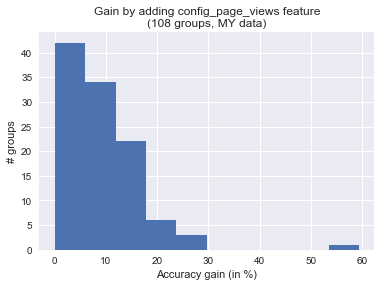

In [23]:
# Gain
acc_gain = res.query('delta_medape > 0')['delta_medape']
_ = acc_gain.hist()
t1 = 'Gain by adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_gain.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy gain (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + '{}_gain_hist.pdf'.format(country))

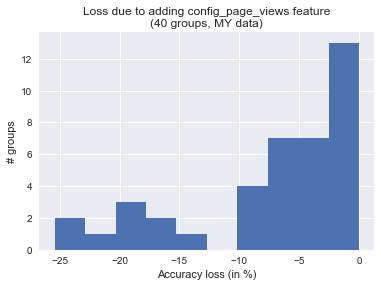

In [24]:
# Loss
acc_loss = res.query('delta_medape <= 0')['delta_medape']
_ = acc_loss.hist()
t1 = 'Loss due to adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_loss.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy loss (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + '{}_loss_hist.pdf'.format(country))

### Aggregated gain/loss

In [25]:
pre_err['use_config_page_views'] = 'N'
post_err['use_config_page_views'] = 'Y'
sample_best_err = pd.concat([pre_err, post_err])

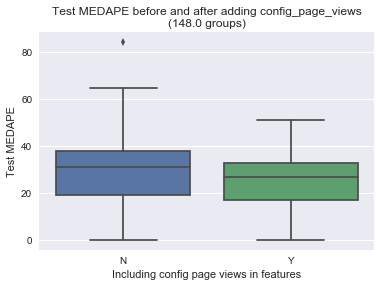

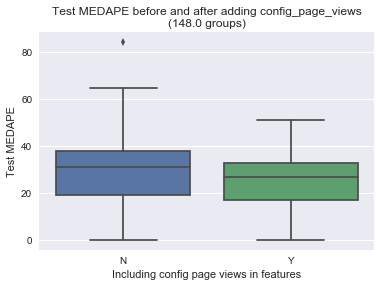

In [36]:
n_group = sample_best_err.shape[0]/2
title = 'Test MEDAPE before and after adding {}'.format(add_feat) + '\n' + '({} groups)'.format(n_group)
plot_gain(sample_best_err, title)

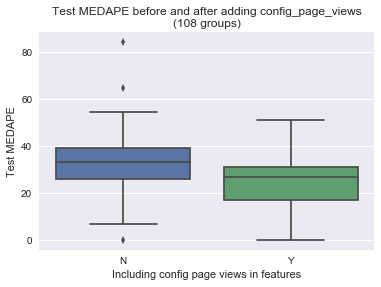

In [27]:
# Gain
gain_df = sample_best_err[sample_best_err.group.isin(gain_groups)]
n_gain = len(gain_groups)

title = 'Test MEDAPE before and after adding {}'.format(add_feat) + '\n' + '({} groups)'.format(n_gain)
fig = plot_gain(gain_df, title)
plt.savefig(add_feat_dir + '{}_gain_box.pdf'.format(country))

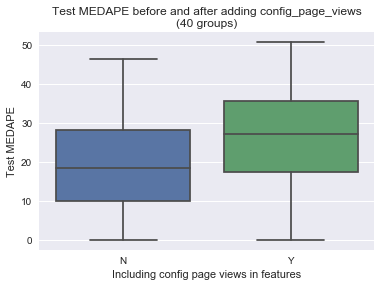

In [28]:
# Loss
loss_df = sample_best_err[sample_best_err.group.isin(loss_groups)]
n_loss = len(loss_groups)
title = 'Test MEDAPE before and after adding {}'.format(add_feat) + '\n' + '({} groups)'.format(n_loss)
fig = plot_gain(loss_df, title)
plt.savefig(add_feat_dir + '{}_loss_box.pdf'.format(country))

### Why lose accuracy

In [33]:
# get stats of the groups
stats = pd.read_csv(dat_dir + 'stats.csv')
res = res.rename(columns={'group': 'group_id'})
res = pd.merge(res, stats)

# add accuracy state
res['acc_state'] = res['delta_medape'].apply(to_state)

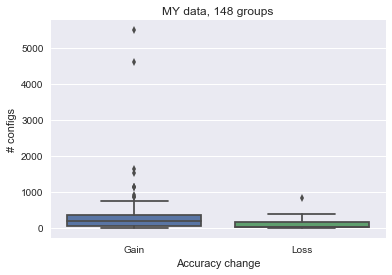

In [34]:
fig = acc_gain_vs_configs(res, country)
plt.savefig(add_feat_dir + '{}_acc_gain_vs_configs.pdf'.format(country))

## For SG data

In [304]:
# dirs
country = 'sg'
dat_dir = '/Users/gfg/data/markdown/clean/venture=Zalora/{}/'.format(country)
res_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/{}/'.format(country)
sample_dir = res_dir + 'sample/'
add_feat_dir = sample_dir + 'add_' + add_feat + '/'

In [290]:
err_df, sample_err = load_metrics(country='sg')

Loading error metrics for country sg...
Done


In [291]:
groups = err_df.group.unique()
sample_groups = sample_err['group'].unique()
print('# trained groups: {}'.format(len(groups)))
print('# trained sample groups: {}'.format(len(sample_groups)))

# trained groups: 522
# trained sample groups: 149


In [292]:
best_err = get_best_err(err_df)

In [293]:
# error before adding config_page_views
pre_err = best_err[best_err['group'].isin(sample_groups)]
pre_err = drop_train_errors(pre_err)
pre_err['test_medape'].describe()

count    149.000000
mean      24.088997
std       13.882672
min        0.000000
25%       11.524975
50%       22.306311
75%       34.521794
max       73.054865
Name: test_medape, dtype: float64

In [294]:
# error after adding config_page_views
post_err = get_best_err(sample_err)
post_err = drop_train_errors(post_err)
post_err['test_medape'].describe()

count    149.000000
mean      16.433009
std        9.517461
min        0.000000
25%        8.763635
50%       15.021151
75%       22.906423
max       46.337926
Name: test_medape, dtype: float64

__Obs__: There is also significant gain for SG data if we add the feature.

### Individual gain/loss

In [295]:
res = cal_acc_gain(pre_err, post_err)

In [268]:
res.delta_medape.describe()

count    149.000000
mean       7.655988
std       13.172484
min      -28.343610
25%       -0.779897
50%        6.486416
75%       14.842927
max       66.612035
Name: delta_medape, dtype: float64

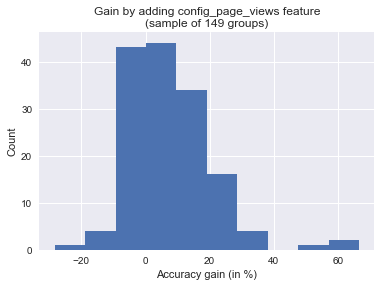

In [269]:
# histogram of accuracy gain/loss
_ = res['delta_medape'].hist()
tt = 'Gain by adding config_page_views feature' + '\n' + '(sample of {} groups)'.format(len(sample_groups))
plt.title(tt)
plt.xlabel('Accuracy gain (in %)'); plt.ylabel('Count')

We can see that for most groups, we achieve gain in accuracy after adding feature `config_page_views`. Only for 25% of groups, we lose accuracy. Let us take closer look on both cases.

In [296]:
gain_groups = res.query('delta_medape > 0')['group']
loss_groups = res.query('delta_medape <= 0')['group']

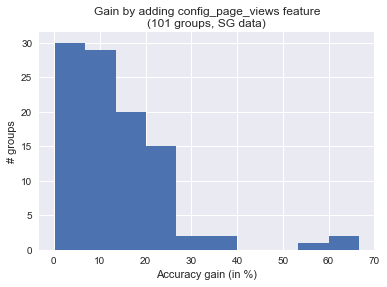

In [271]:
# Gain
acc_gain = res.query('delta_medape > 0')['delta_medape']
_ = acc_gain.hist()
t1 = 'Gain by adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_gain.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy gain (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + 'gain_hist.pdf')

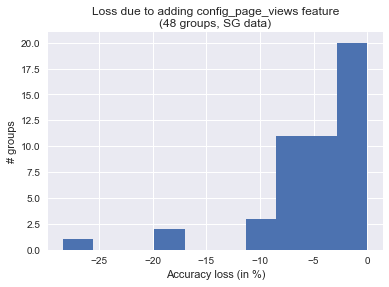

In [272]:
# Loss
acc_loss = res.query('delta_medape <= 0')['delta_medape']
_ = acc_loss.hist()
t1 = 'Loss due to adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_loss.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy loss (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + 'loss_hist.pdf')

### Why loss?

In [323]:
# get stats of the groups
stats = pd.read_csv(dat_dir + 'stats.csv')
res = res.rename(columns={'group': 'group_id'})
res = pd.merge(res, stats)

# add accuracy state
res['acc_state'] = res['delta_medape'].apply(to_state)

In [327]:
# gain vs. loss
gain_df = res.query('delta_medape > 0')
gain_df = drop_irrelevant(gain_df)

loss_df = res.query('delta_medape < 0')
loss_df = drop_irrelevant(loss_df)

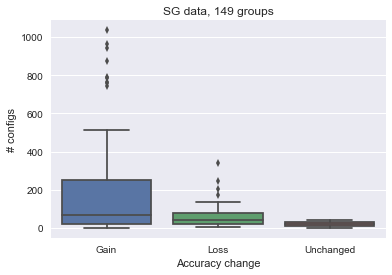

In [338]:
fig = acc_gain_vs_configs(res, country)
plt.savefig(add_feat_dir + 'acc_gain_vs_configs.pdf')

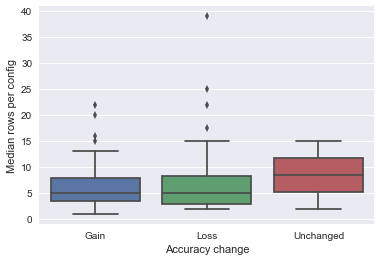

In [330]:
# accuracy change vs. median rows per config
sns.boxplot(x='acc_state', y='med_rows_per_config', data=res)
_ = plt.xlabel('Accuracy change'); _ = plt.ylabel('Median rows per config')

In [328]:
loss_df = loss_df.sort_values('delta_medape')
loss_df

,pre_model,pre_test_medape,group_id,post_model,post_test_medape,delta_medape,avg_rows_per_config,max_rows_per_config,med_rows_per_config,min_rows_per_config,n_config,acc_state
115,XGBoost,1.929969,sports_lifestyle_backpacks_unisex_autumn,Ridge Regression,30.273579,-28.343610,15.500000,23.0,15.0,9.0,4.0,Loss
129,XGBoost,7.439172,sports_lifestyle_shoes_male_spring_summer,XGBoost,25.836241,-18.397069,7.130841,54.0,5.0,1.0,107.0,Loss
109,XGBoost,10.599220,sports_lifestyle_bottoms_female_autumn_winter,Lasso Regression,28.656215,-18.056995,9.290323,82.0,5.0,1.0,31.0,Loss
125,XGBoost,26.160932,socks_unisex_autumn_winter,XGBoost,37.203825,-11.042893,5.875000,10.0,5.5,2.0,8.0,Loss
44,XGBoost,11.011314,sports_performance_bottoms_male_year_round,XGBoost,20.444965,-9.433651,11.404762,35.0,10.0,1.0,42.0,Loss
112,XGBoost,2.714825,sports_lifestyle_backpacks_unisex_year_round,XGBoost,11.233282,-8.518457,4.200000,11.0,4.0,1.0,15.0,Loss
121,XGBoost,21.932065,sneakers_unisex_spring_summer,XGBoost,30.290490,-8.358425,6.500000,34.0,5.0,1.0,44.0,Loss
49,XGBoost,9.701955,sports_performance_shoes_female_spring_summer,XGBoost,17.746556,-8.044600,4.088608,26.0,3.0,1.0,79.0,Loss
142,XGBoost,6.981212,sports_lifestyle_bottoms_male_summer,Ridge Regression,14.781668,-7.800457,10.333333,24.0,5.5,3.0,6.0,Loss
107,XGBoost,26.989150,sports_bra_female_summer,Ridge Regression,34.333520,-7.344370,25.500000,61.0,22.0,1.0,10.0,Loss


__Obs__: Most groups with loss in accuracy are under __sport__ category.

#### Groups with largest loss

In [329]:
loss_df.head()

,pre_model,pre_test_medape,group_id,post_model,post_test_medape,delta_medape,avg_rows_per_config,max_rows_per_config,med_rows_per_config,min_rows_per_config,n_config,acc_state
115,XGBoost,1.929969,sports_lifestyle_backpacks_unisex_autumn,Ridge Regression,30.273579,-28.343610,15.500000,23.0,15.0,9.0,4.0,Loss
129,XGBoost,7.439172,sports_lifestyle_shoes_male_spring_summer,XGBoost,25.836241,-18.397069,7.130841,54.0,5.0,1.0,107.0,Loss
109,XGBoost,10.599220,sports_lifestyle_bottoms_female_autumn_winter,Lasso Regression,28.656215,-18.056995,9.290323,82.0,5.0,1.0,31.0,Loss
125,XGBoost,26.160932,socks_unisex_autumn_winter,XGBoost,37.203825,-11.042893,5.875000,10.0,5.5,2.0,8.0,Loss
44,XGBoost,11.011314,sports_performance_bottoms_male_year_round,XGBoost,20.444965,-9.433651,11.404762,35.0,10.0,1.0,42.0,Loss


In [303]:
bad_groups = loss_df.head()['group']

In [ ]:
bad

### Aggregated gain/loss

In [273]:
pre_err['use_config_page_views'] = 'N'
post_err['use_config_page_views'] = 'Y'
sample_best_err = pd.concat([pre_err, post_err])

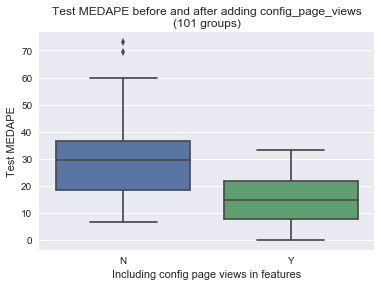

In [274]:
# Gain
gain_df = sample_best_err[sample_best_err.group.isin(gain_groups)]
n_gain = len(gain_groups)

title = 'Test MEDAPE before and after adding {}'.format(add_feat) + '\n' + '({} groups)'.format(n_gain)
fig = plot_gain(gain_df, title)
plt.savefig(add_feat_dir + 'gain_box.pdf')

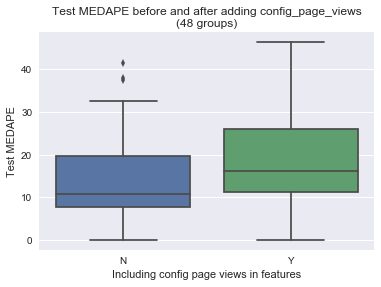

In [275]:
# Loss
loss_df = sample_best_err[sample_best_err.group.isin(loss_groups)]
n_loss = len(loss_groups)
title = 'Test MEDAPE before and after adding {}'.format(add_feat) + '\n' + '({} groups)'.format(n_loss)
fig = plot_gain(loss_df, title)
plt.savefig(add_feat_dir + 'loss_box.pdf')

Median gain is about 15% while median loss is less than 10%.

## For ID data

In [339]:
# dirs
country = 'id'
dat_dir = '/Users/gfg/data/markdown/clean/venture=Zalora/{}/'.format(country)
res_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/{}/'.format(country)
sample_dir = res_dir + 'sample/'
add_feat_dir = sample_dir + 'add_' + add_feat + '/'

In [340]:
err_df, sample_err = load_metrics(country='id')

Loading error metrics for country id...
Done


In [341]:
best_err = get_best_err(err_df)

In [355]:
# error before adding config_page_views
sample_groups = list(sample_err.group.unique())
pre_err = best_err[best_err['group'].isin(sample_groups)]
pre_err = drop_train_errors(pre_err)
pre_err['test_medape'].describe()

count    147.000000
mean      17.690388
std       10.638229
min        0.000000
25%        9.775549
50%       15.821981
75%       25.368166
max       49.549150
Name: test_medape, dtype: float64

In [343]:
# error after adding config_page_views
post_err = get_best_err(sample_err)
post_err = drop_train_errors(post_err)
post_err['test_medape'].describe()

count    147.000000
mean      12.747692
std        8.156240
min        0.000000
25%        7.045525
50%       11.029625
75%       17.065744
max       38.278381
Name: test_medape, dtype: float64

###  Individual gain/loss

In [354]:
res = cal_acc_gain(pre_err=pre_err, post_err=post_err)
res.delta_medape.describe()

count    147.000000
mean       4.942696
std        8.608706
min      -15.787142
25%       -0.792965
50%        3.989482
75%        9.828751
max       38.447071
Name: delta_medape, dtype: float64

__Obs__: Results are also the same as for SG data.

In [283]:
gain_groups = res.query('delta_medape > 0')['group']
loss_groups = res.query('delta_medape <= 0')['group']

In [284]:
print('# groups with gain in acc: {}'.format(len(gain_groups)))
print('# groups with loss in acc: {}'.format(len(loss_groups)))

# groups with gain in acc: 101
# groups with loss in acc: 46


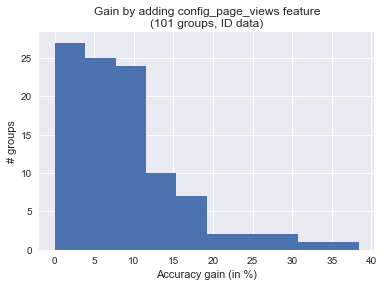

In [285]:
# Gain
acc_gain = res.query('delta_medape > 0')['delta_medape']
_ = acc_gain.hist()
t1 = 'Gain by adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_gain.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy gain (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + 'gain_hist.pdf')

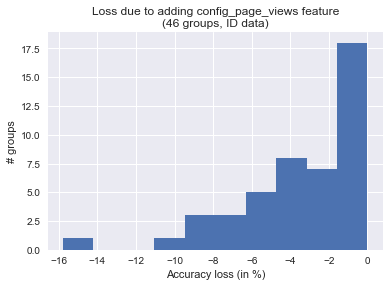

In [286]:
# Loss
acc_loss = res.query('delta_medape <= 0')['delta_medape']
_ = acc_loss.hist()
t1 = 'Loss due to adding {0} feature'.format(add_feat)
t2 = '({0} groups, {1} data)'.format(acc_loss.shape[0], country.upper())
tt = t1 + '\n' + t2
plt.title(tt)
plt.xlabel('Accuracy loss (in %)'); plt.ylabel('# groups')
plt.savefig(add_feat_dir + 'loss_hist.pdf')

#### Why loss?

In [356]:
# get stats of the groups
stats = pd.read_csv(dat_dir + 'stats.csv')
res = res.rename(columns={'group': 'group_id'})
res = pd.merge(res, stats)

# add accuracy state
res['acc_state'] = res['delta_medape'].apply(to_state)

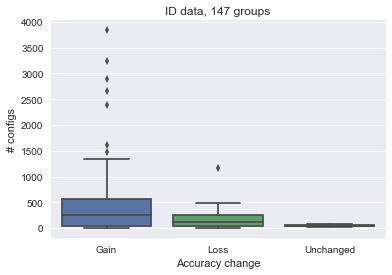

In [358]:
fig = acc_gain_vs_configs(res, country)
plt.savefig(add_feat_dir + 'acc_gain_vs_configs.pdf')

__Obs__: Gain groups have more configs than loss groups, this is True for both ID and SG data.

### Aggregated gain/loss

In [255]:
pre_err['use_config_page_views'] = 'N'
post_err['use_config_page_views'] = 'Y'
sample_best_err = pd.concat([pre_err, post_err])

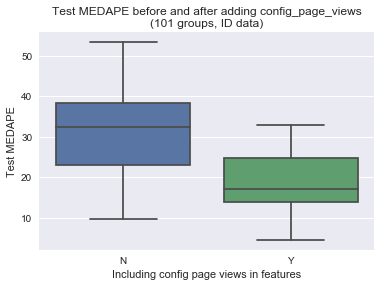

In [287]:
# Gain
gain_df = sample_best_err[sample_best_err.group.isin(gain_groups)]
n_gain = len(gain_groups)
t1 = 'Test MEDAPE before and after adding {}'.format(add_feat)
t2 = '({} groups, {} data)'.format(n_gain, country.upper())
title = t1 + '\n' + t2
fig = plot_gain(gain_df, title)
plt.savefig(add_feat_dir + 'gain_box.pdf')

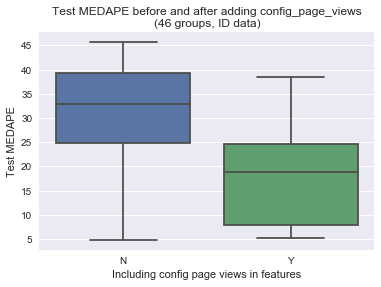

In [288]:
# Loss
loss_df = sample_best_err[sample_best_err.group.isin(loss_groups)]
n_loss = len(loss_groups)
t1 = 'Test MEDAPE before and after adding {}'.format(add_feat)
t2 = '({} groups, {} data)'.format(n_loss, country.upper())
title = t1 + '\n' + t2
fig = plot_gain(loss_df, title)
plt.savefig(add_feat_dir + 'loss_box.pdf')

Median gain is almost 10% while median loss is only 2%.

## Best models
For sample groups

In [77]:
n_group = best_err_after.shape[0]

In [78]:
100.0 * best_err_after.post_model.value_counts()/n_group

XGBoost                    76.767677
Random Forest              16.161616
Boosted Regression Tree     3.030303
Lasso Regression            2.020202
Ridge Regression            2.020202
Name: post_model, dtype: float64

__Obs__:
We can see that XGBoost is usually the best model. It is the best model for more than 75% of groups.

## Gain vs. amount of data
For each group, its amount of data is measured by median number of transactional records (over configs).

In [95]:
stats = pd.read_csv(dat_dir + 'stats.csv')

In [96]:
stats.columns

Index(['group_id', 'avg_rows_per_config', 'max_rows_per_config',
       'med_rows_per_config', 'min_rows_per_config', 'n_config'],
      dtype='object')

In [104]:
sample_stats = stats[stats.group_id.isin(sample_groups)]

In [105]:
sample_stats.med_rows_per_config.describe()

count    99.000000
mean      5.570707
std       5.404085
min       1.000000
25%       3.000000
50%       4.000000
75%       6.000000
max      45.000000
Name: med_rows_per_config, dtype: float64

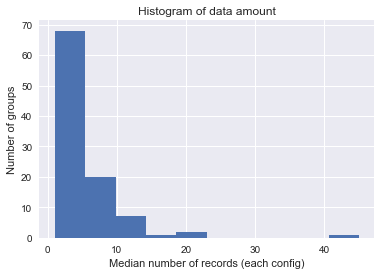

In [108]:
_ = sample_stats.med_rows_per_config.hist() 
plt.xlabel(r'Median number of records (each config)'); plt.ylabel('Number of groups')
plt.title('Histogram of data amount')
plt.savefig(folder + 'data_amount.pdf')

# Accuracy gain via adding both features 
Add both: `is_new` and `config_page_views`.

In [19]:
def load_errors(country='sg'):
    sample_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/{}/sample/'.format(country)
    folder1 = sample_dir + 'add_config_page_views/'
    folder2 = sample_dir + 'add_is_new/'

    err1 = get_best_err(load_metrics_files(folder1))
    err2 = get_best_err(load_metrics_files(folder2))
    return err1, err2

In [21]:
def viz_indi_error_change(res, country='sg'):
    _ = res.delta_medape.hist()
    plt.xlabel('Accuracy delta (in % of actual value)'); plt.ylabel('# groups')
    plt.title('Delta of accuracy ({0} data, {1} groups)'.format(country.upper(), sample_size))
    plt.savefig(sample_dir + 'add_is_new/{}_indi_err.pdf'.format(country))

## For SG

In [ ]:
err1, err2 = load_errors(country='sg')

In [26]:
# flag which additional feats are used
err1['added_feature'] = 'config_page_views'
err2['added_feature'] = 'config_page_views & is_new'
sample_err = pd.concat([err1, err2])

In [33]:
sample_size = err2.shape[0]

### Individual gain/loss

In [35]:
res = cal_acc_gain(err1, err2)

In [37]:
res.delta_medape.describe()

count    149.000000
mean      -8.123166
std       12.355481
min      -75.660475
25%      -12.576747
50%       -7.199371
75%       -0.804400
max       16.931432
Name: delta_medape, dtype: float64

In [ ]:
viz_indi_error_change(res, country='sg')

__Obs:__ we lose accuracy most of the time (For 75% of groups)!!!

### Aggregated gain/loss

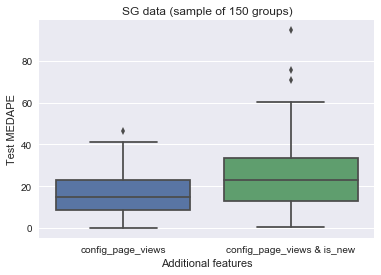

In [41]:
fig = plot_gain(sample_err, tt='SG data (sample of {} groups)'.format(sample_size), 
                xcol='added_feature', ycol='test_medape', 
              xl='Additional features', yl='Test MEDAPE')

plt.savefig(sample_dir + 'add_is_new/' + 'sg_agg_err.pdf')

__Obs__: error is increased when we add `is_new`!!!

### Against baseline 
baseline = when no additional feature is used

In [13]:
err_df, sample_err = load_metrics(country='sg', add_feat='is_new')

Loading error metrics for country sg...
Done


In [14]:
groups = err_df.group.unique()
sample_groups = sample_err['group'].unique()
print('# trained groups: {}'.format(len(groups)))
print('# trained sample groups: {}'.format(len(sample_groups)))

# trained groups: 522
# trained sample groups: 150


In [16]:
best_err = get_best_err(err_df)

In [17]:
# error before adding the feature
pre_err = best_err[best_err['group'].isin(sample_groups)]
pre_err = drop_train_errors(pre_err)
pre_err['test_medape'].describe()

count    149.000000
mean      24.088997
std       13.882672
min        0.000000
25%       11.524975
50%       22.306311
75%       34.521794
max       73.054865
Name: test_medape, dtype: float64

In [18]:
# error after adding the feature
post_err = get_best_err(sample_err)
post_err = drop_train_errors(post_err)
post_err['test_medape'].describe()

count    149.000000
mean      24.556175
std       14.941427
min        0.296015
25%       12.939310
50%       22.781873
75%       33.678699
max       94.733572
Name: test_medape, dtype: float64

__ Obs:__
Adding only feature `is_new` increases prediction error. Thus, we need to try adding both features `is_new` and `config_page_views` instead of adding only one of them.

## For ID

## For MY

In [13]:
# load error metrics
sample_dir = '/Users/gfg/projects/daas-markdown/res/Zalora/my/sample/'
folder1 = sample_dir + 'add_config_page_views/'
folder2 = sample_dir + 'add_is_new/'

err1 = get_best_err(load_metrics_files(folder1))
err2 = get_best_err(load_metrics_files(folder2))

In [14]:
# flag which additional feats are used
err1['added_feature'] = 'config_page_views'
err2['added_feature'] = 'config_page_views & is_new'
sample_err = pd.concat([err1, err2])

In [15]:
sample_size = err2.shape[0]

### Individual gain/loss

In [16]:
res = cal_acc_gain(err1, err2)

In [17]:
res.delta_medape.describe()

count    147.000000
mean      -1.875791
std       10.084488
min      -30.189925
25%       -6.048779
50%       -1.205593
75%        1.817513
max       28.961939
Name: delta_medape, dtype: float64

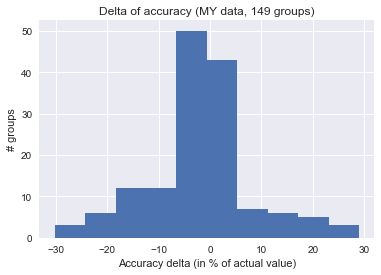

In [22]:
viz_indi_error_change(res, country='my')

__Obs:__ most of the time, changes are small. Thus adding both features `is_new` and `config_page_views` does not significantly change over adding only `config_page_views`.

# Feature importance

For each group, we want to know which features are important. This can be done if the best DP model for the group is a tree-based model.

In [13]:
fname = model_dir + 'feat_importance.csv'
df = pd.read_csv(fname)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 3 columns):
feature             536 non-null object
group               536 non-null object
importance_score    536 non-null float64
dtypes: float64(1), object(2)
memory usage: 12.6+ KB


## Most important features

In [14]:
df2 = pd.read_csv(model_dir + 'most_important.csv')
df2.head()

,most_important_feature,group,importance_score
0,scaled_brand_pop,backpacks_female_autumn-winter_2017,0.515385
1,scaled_rel_price_as_ratio,backpacks_female_spring-summer_2017,0.621495
2,scaled_brand_pop,backpacks_male_spring-summer_2017,0.533708
3,scaled_n_competitor,backpacks_unisex_spring-summer_2017,0.289855
4,scaled_brand_pop,blouses_&_tunics_female_spring-summer_2017,0.307143


In [15]:
df2.most_important_feature.value_counts()

scaled_brand_pop                    46
scaled_rel_price_as_ratio           11
scaled_n_competitor                  3
scaled_color_pop                     2
scaled_current_price                 2
scaled_percent_discount_from_rrp     2
is_weekend                           1
Name: most_important_feature, dtype: int64

__Obs:__ Most of the time, the most important feature is `brand popularity`. The second important feature is `relative price`.

In [11]:
def get_groups(err_df, model='XGBoost'):
    # find groups which accept given model as the best DP model
    df = err_df.query('model == "{}"'.format(model))
    groups = df.group.unique()
    return groups

In [12]:
models = ['XGBoost', 'Lasso Regression', 'Boosted Regression Tree', 'Random Forest', 'Ridge Regression']

In [13]:
# list number of groups for each model
n_group1 = [len(get_groups(err_df=best_err1, model=m)) for m in models]
n_group2 = [len(get_groups(err_df=best_err2, model=m)) for m in models]
res1 = pd.DataFrame({'model': models, 'n_group': n_group1, 'used_features': 'original'})
res2 = pd.DataFrame({'model': models, 'n_group': n_group2, 'used_features': 'normalized'})
print(sum(res1.n_group)); print(sum(res2.n_group))
pd.concat([res1, res2])

110
110


,model,n_group,used_features
0,XGBoost,43,original
1,Lasso Regression,34,original
2,Boosted Regression Tree,20,original
3,Random Forest,11,original
4,Ridge Regression,2,original
0,XGBoost,41,normalized
1,Lasso Regression,40,normalized
2,Boosted Regression Tree,16,normalized
3,Random Forest,10,normalized
4,Ridge Regression,3,normalized


## Groups for which XGB is the best

In [50]:
to_drop = [c for c in best_err2.columns if 'train_' in c] # drop train errors
xgb_df = best_err2.query('model == "XGBoost"').drop(to_drop, axis=1)

In [51]:
xgb_df.sort_values('n_config', ascending=False, inplace=True)
xgb_df.head()

,model,test_medae,test_medape,test_rmse,group,n_config,avg_records_per_config,used_features
460,XGBoost,0.146458,12.783933,0.906703,tops_female_spring-summer_2017,1462,8.0,normalized
435,XGBoost,0.082024,8.202422,0.428657,t-shirts_male_spring-summer_2017,979,5.0,normalized
430,XGBoost,0.096288,9.628832,0.463037,t-shirts_male_autumn-winter_2017,763,7.0,normalized
215,XGBoost,0.124277,12.427664,0.699761,shirts_male_spring-summer_2017,571,6.0,normalized
25,XGBoost,0.222024,17.811060,0.880447,blouses_&_tunics_female_spring-summer_2017,409,7.0,normalized


### Most important feature

In [54]:
import joblib

In [55]:
fname = model_dir + 'blouses_&_tunics_female_spring-summer_2017.pkl'
model = joblib.load(fname)

KeyError: '/'

In [ ]:
def find_most_important_feat(gr):
    fname = model_dir + gr + '.pkl'
    model = jl.load(fname)
    feat_importances = model.

In [ ]:
xgb_groups = list(xgb_df.group)